In [1]:
import random
import pandas as pd
import numpy as np
from pathlib import Path
import os
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch

import matplotlib.pyplot as plt

class ConfigStruct:
    def __init__(self, **entries):
        self.__dict__.update(entries)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [3]:
config = dict(
    epochs=100,
    batch_size=2048,
    learning_rate=0.008,
    weight_decay=1e-5,
    dropout=0.05,
    shuffle=True,
    test_size=0.2,
    split_seed=42,
    random_seed=1234,
    stratified_split=False,
    smooth_l1_loss_beta=1.0
)

In [4]:
MODEL_FILENAME = "Model_A.pth"
MODEL_DIR = "../models"
MODEL_PATH = Path(MODEL_DIR, MODEL_FILENAME)

DATASET_DIR = "../data"
DATASET_NAME = "blue_waters_posix_no_outliers"
DATASET_PATH = Path(DATASET_DIR, DATASET_NAME).with_suffix(".csv")

CSV_LOG_PATH = "../results/training/Model_A_test_loss.csv"

In [5]:
if not os.path.exists(CSV_LOG_PATH):
    with open(CSV_LOG_PATH, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["epoch", "test_loss"])

In [6]:
# Load the data
df_blue_waters_posix = pd.read_csv(DATASET_PATH)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,1280,-1281,-1281,1807,0,0,2561,0,0,-1281,...,0.000000,0.000000,1540486184,1540486762,213,579.0,3.1,./Hsigma,1,0.883451
1,168420,-5232,-5232,7505724,5401751,11345341,394840,0,1,-5232,...,0.000000,1.294190,1540414582,1540499232,80,84651.0,3.1,./SpEC,1,126.224526
2,2366,-2367,-2367,3342,0,0,4733,0,0,-2367,...,0.000000,0.000000,1540498498,1540499201,394,704.0,3.1,./Hsigma,1,3.233117
3,8709,-288,-288,1521073,6331589,2013343,28430,0,0,-288,...,0.000000,56.737093,1540442491,1540443028,256,538.0,3.1,CCTM_v52_Linux2_x86_64intel,1,364.725531
4,8709,-288,-288,1516465,8334307,2006943,28430,0,0,-288,...,0.000000,56.462348,1540441741,1540442347,256,607.0,3.1,CCTM_v52_Linux2_x86_64intel,1,365.198932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.000000,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
724027,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.000000,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095
724028,244,-77,-77,3960,5,2645,499,0,0,-77,...,0.000234,0.197681,1506699687,1506699703,1,17.0,3.1,ApplyObservers -domaininput=GrDomain.input -No...,1,97.547204
724029,9927,-890,-890,3640566,3018272,5706358,176916,0,1,-890,...,0.000000,0.715079,1506612023,1506695745,48,83723.0,3.1,./SpEC,1,141.832395


In [7]:
# Remove all records with zero in the "bandwidth" column
df_blue_waters_posix = df_blue_waters_posix[df_blue_waters_posix["bandwidth"] != 0]
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,start_time_sec,end_time_sec,nprocs,run_time,log_ver,exe,lustre,bandwidth
0,1280,-1281,-1281,1807,0,0,2561,0,0,-1281,...,0.000000,0.000000,1540486184,1540486762,213,579.0,3.1,./Hsigma,1,0.883451
1,168420,-5232,-5232,7505724,5401751,11345341,394840,0,1,-5232,...,0.000000,1.294190,1540414582,1540499232,80,84651.0,3.1,./SpEC,1,126.224526
2,2366,-2367,-2367,3342,0,0,4733,0,0,-2367,...,0.000000,0.000000,1540498498,1540499201,394,704.0,3.1,./Hsigma,1,3.233117
3,8709,-288,-288,1521073,6331589,2013343,28430,0,0,-288,...,0.000000,56.737093,1540442491,1540443028,256,538.0,3.1,CCTM_v52_Linux2_x86_64intel,1,364.725531
4,8709,-288,-288,1516465,8334307,2006943,28430,0,0,-288,...,0.000000,56.462348,1540441741,1540442347,256,607.0,3.1,CCTM_v52_Linux2_x86_64intel,1,365.198932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,0.000000,0.914386,1506629880,1506630161,48,282.0,3.1,./SpEC,1,164.318747
724027,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,0.000000,0.752825,1506647712,1506651237,48,3526.0,3.1,./SpEC,1,236.018095
724028,244,-77,-77,3960,5,2645,499,0,0,-77,...,0.000234,0.197681,1506699687,1506699703,1,17.0,3.1,ApplyObservers -domaininput=GrDomain.input -No...,1,97.547204
724029,9927,-890,-890,3640566,3018272,5706358,176916,0,1,-890,...,0.000000,0.715079,1506612023,1506695745,48,83723.0,3.1,./SpEC,1,141.832395


In [8]:
df_blue_waters_posix = df_blue_waters_posix.drop(["start_time_sec", "end_time_sec", "run_time", "log_ver", "exe", "lustre"], axis=1)
df_blue_waters_posix

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs,bandwidth
0,1280,-1281,-1281,1807,0,0,2561,0,0,-1281,...,0.000082,0.000000,0.970416,0.970498,0.081013,0.000000,0.000000,0.000000,213,0.883451
1,168420,-5232,-5232,7505724,5401751,11345341,394840,0,1,-5232,...,112.250101,33.734686,1.555623,147.540409,0.316154,0.379682,0.000000,1.294190,80,126.224526
2,2366,-2367,-2367,3342,0,0,4733,0,0,-2367,...,0.000108,0.000000,0.487019,0.487127,0.064347,0.000000,0.000000,0.000000,394,3.233117
3,8709,-288,-288,1521073,6331589,2013343,28430,0,0,-288,...,14358.530507,25.607961,5.596620,14389.735087,0.506723,0.303372,0.000000,56.737093,256,364.725531
4,8709,-288,-288,1516465,8334307,2006943,28430,0,0,-288,...,14303.609844,32.291772,4.555102,14340.456718,0.354845,1.372775,0.000000,56.462348,256,365.198932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724026,27899,-706,-706,824117,136902,632480,70722,0,1,-706,...,32.179977,0.000000,4.170172,36.350149,0.152006,0.266960,0.000000,0.914386,48,164.318747
724027,12571,-1000,-1000,781645,355445,653876,80989,0,1,-1000,...,23.145645,0.000000,2.337891,25.483536,0.118279,0.305436,0.000000,0.752825,48,236.018095
724028,244,-77,-77,3960,5,2645,499,0,0,-77,...,0.193506,0.001196,0.095079,0.289781,0.051202,0.000581,0.000234,0.197681,1,97.547204
724029,9927,-890,-890,3640566,3018272,5706358,176916,0,1,-890,...,9.836940,56.458354,8.410483,74.705777,0.124667,0.484447,0.000000,0.715079,48,141.832395


In [9]:
# Separate bandwidth from input features
bandwidth_df = df_blue_waters_posix.pop('bandwidth')
bandwidth_df

0           0.883451
1         126.224526
2           3.233117
3         364.725531
4         365.198932
             ...    
724026    164.318747
724027    236.018095
724028     97.547204
724029    141.832395
724030    156.583380
Name: bandwidth, Length: 682576, dtype: float64

In [10]:
# Fix seeds for reproducibility
random.seed(config["random_seed"])
np.random.seed(config["random_seed"])

torch.manual_seed(config["random_seed"])
torch.cuda.manual_seed_all(config["random_seed"])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [11]:
config = ConfigStruct(**config)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_blue_waters_posix,
                                                    bandwidth_df,
                                                    test_size=config.test_size,
                                                    random_state=config.split_seed,
                                                    stratify=df_blue_waters_posix["nprocs"] if config.stratified_split else None)

In [13]:
non_numeric_columns = X_train.select_dtypes(include='object').columns
non_numeric_columns

Index([], dtype='object')

In [14]:
X_train = X_train.drop(columns=non_numeric_columns)
X_train

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,rank,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs
295549,4766,-724,-724,212202,133752,201066,15301,0,1,-724,...,-1,20.117020,0.000000,1.588297,21.705316,0.057065,0.653503,0.0,0.603932,48
120151,176,-34,-34,1254,792,1683,363,0,0,-34,...,1,0.251346,0.380341,0.007311,0.638998,0.215383,0.330592,0.0,0.002589,11
22415,567,-272,-272,4718,26400,14572,895,0,0,-272,...,0,0.309271,0.388447,0.217728,0.915447,0.025227,0.076052,0.0,0.057293,16
410942,5660,-882,-882,517712,378991,586390,25734,0,1,-882,...,-1,30.813317,0.000000,4.549907,35.363224,0.179827,0.276169,0.0,1.037294,48
226986,13434,-1213,-1213,1544590,902708,1998069,79705,0,1,-1213,...,-1,18.388539,0.000000,4.667251,23.055790,0.459195,0.780191,0.0,0.444116,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275711,858,-20,-20,123598,42008793,16411,874,0,0,-20,...,-1,11.171406,203.477590,0.839382,215.488378,0.199369,0.795786,0.0,206.708719,16
390036,115,-13,-13,45728,10984,77,228,0,0,-13,...,-1,8.091754,0.000000,0.128993,8.220747,0.022282,0.102872,0.0,0.556193,16
139924,53936,-1214,-1214,5245698,4359430,6529791,622129,0,1,-1214,...,0,13.111555,149.421476,16.649764,179.182795,0.145024,1.398725,0.0,1.309408,48
711958,17621,-875,-875,3802721,3344715,5386709,391749,0,1,-875,...,-1,21.279668,0.000000,1141.087554,1162.367222,0.166792,1.143757,0.0,29.847672,48


In [15]:
X_test = X_test.drop(columns=non_numeric_columns)
X_test

,POSIX_OPENS,POSIX_FILENOS,POSIX_DUPS,POSIX_READS,POSIX_WRITES,POSIX_SEEKS,POSIX_STATS,POSIX_MMAPS,POSIX_FSYNCS,POSIX_RENAME_SOURCES,...,rank,POSIX_F_READ_TIME,POSIX_F_WRITE_TIME,POSIX_F_META_TIME,POSIX_TOTAL_TIME,POSIX_F_MAX_READ_TIME,POSIX_F_MAX_WRITE_TIME,POSIX_F_FASTEST_RANK_TIME,POSIX_F_SLOWEST_RANK_TIME,nprocs
150366,5127,-8,-8,17075,4763,500,2055,0,0,-8,...,-1,25.862106,0.000000,21.186783,47.048889,0.035673,0.000573,0.000000,25.864859,1024
676351,1025,-1,-1,0,8,1,1,0,0,-1,...,-1,0.000000,0.017293,0.871289,0.888582,0.000000,0.004506,0.000321,0.027398,1024
256465,8709,-288,-288,1520561,6330481,2010527,28430,0,0,-288,...,-1,16852.574240,58.379657,4.444484,16915.398381,1.102125,0.653191,0.000000,69.096872,256
145355,137039,-8810,-8810,1600248,1033617,2270238,352317,0,1,-8810,...,-1,39.425392,0.000000,0.928666,40.354058,0.285228,1.425272,0.000000,0.508379,128
364279,3124,-20,-20,139011,25926804,60619,3188,0,0,-20,...,-1,10.794647,122.264171,22.689607,155.748425,0.102943,1.188776,0.000000,123.398741,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287709,4842,-790,-790,211116,131473,202624,14960,0,1,-790,...,-1,57.817494,0.000000,1.759531,59.577025,0.323823,0.218312,0.000000,1.410457,48
239496,1025,-1,-1,0,8,1,1,0,0,-1,...,-1,0.000000,0.014025,0.908601,0.922626,0.000000,0.001921,0.000037,0.025392,1024
718103,8709,-288,-288,1511994,6327001,2003389,28430,0,0,-288,...,-1,23014.022017,27.741339,206.777455,23248.540810,102.788349,0.699649,0.000000,102.799000,256
438853,212,-14,-14,91456,13855,119,421,0,0,-14,...,-1,20.575002,0.000000,0.702605,21.277607,0.081565,0.123856,0.000000,0.731534,32


In [16]:
scaler = StandardScaler().fit(X_train)

In [17]:
# Scale the input features
X_train_scaled = scaler.transform(X_train)
X_train_scaled

array([[-0.01657708,  0.02191973,  0.02191973, ..., -0.00504922,
        -0.09262516, -0.07536735],
       [-0.02082624,  0.04577783,  0.04577783, ..., -0.00504922,
        -0.09378925, -0.09770669],
       [-0.02046427,  0.03754851,  0.03754851, ..., -0.00504922,
        -0.09368335, -0.09468786],
       ...,
       [ 0.02894165,  0.00497702,  0.00497702, ..., -0.00504922,
        -0.09125949, -0.07536735],
       [-0.00467667,  0.01669861,  0.01669861, ..., -0.00504922,
        -0.03601467, -0.07536735],
       [-0.02083827,  0.04598529,  0.04598529, ..., -0.00504922,
        -0.09372206, -0.09468786]])

In [18]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_train = torch.Tensor(X_train_scaled).to(device)
tensor_X_train

tensor([[-0.0166,  0.0219,  0.0219,  ..., -0.0050, -0.0926, -0.0754],
        [-0.0208,  0.0458,  0.0458,  ..., -0.0050, -0.0938, -0.0977],
        [-0.0205,  0.0375,  0.0375,  ..., -0.0050, -0.0937, -0.0947],
        ...,
        [ 0.0289,  0.0050,  0.0050,  ..., -0.0050, -0.0913, -0.0754],
        [-0.0047,  0.0167,  0.0167,  ..., -0.0050, -0.0360, -0.0754],
        [-0.0208,  0.0460,  0.0460,  ..., -0.0050, -0.0937, -0.0947]],
       device='cuda:0')

In [19]:
tensor_y_train = torch.Tensor(y_train.values).view(-1, 1).to(device)  
tensor_y_train

tensor([[ 51.1874],
        [ 30.3521],
        [314.0283],
        ...,
        [134.8450],
        [ 12.0241],
        [520.4371]], device='cuda:0')

In [20]:
training_dataset = TensorDataset(tensor_X_train, tensor_y_train)
training_dataloader = DataLoader(training_dataset, batch_size=config.batch_size, shuffle=config.shuffle)

In [21]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[-0.01624289,  0.04667683,  0.04667683, ..., -0.00504922,
        -0.04372466,  0.51390822],
       [-0.02004028,  0.04691887,  0.04691887, ..., -0.00482473,
        -0.09374122,  0.51390822],
       [-0.01292688,  0.03699528,  0.03699528, ..., -0.00504922,
         0.03996455,  0.05021597],
       ...,
       [-0.01292688,  0.03699528,  0.03699528, ..., -0.00504922,
         0.10520567,  0.05021597],
       [-0.02079291,  0.04646937,  0.04646937, ..., -0.00504922,
        -0.09237814, -0.08502761],
       [-0.02083272,  0.04605444,  0.04605444, ..., -0.00504922,
        -0.09379233, -0.09770669]])

In [22]:
# Transform to a 2D array to avoid shape mismatch (gives errors)
tensor_X_test = torch.Tensor(X_test_scaled).to(device)
tensor_X_test

tensor([[-0.0162,  0.0467,  0.0467,  ..., -0.0050, -0.0437,  0.5139],
        [-0.0200,  0.0469,  0.0469,  ..., -0.0048, -0.0937,  0.5139],
        [-0.0129,  0.0370,  0.0370,  ..., -0.0050,  0.0400,  0.0502],
        ...,
        [-0.0129,  0.0370,  0.0370,  ..., -0.0050,  0.1052,  0.0502],
        [-0.0208,  0.0465,  0.0465,  ..., -0.0050, -0.0924, -0.0850],
        [-0.0208,  0.0461,  0.0461,  ..., -0.0050, -0.0938, -0.0977]],
       device='cuda:0')

In [23]:
tensor_y_test = torch.Tensor(y_test.values).view(-1, 1).to(device)  
tensor_y_test

tensor([[287.7923],
        [  8.1931],
        [310.6908],
        ...,
        [225.0734],
        [ 38.5242],
        [ 31.3455]], device='cuda:0')

In [24]:
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size)

In [25]:
model = nn.Sequential(
    nn.Linear(97, 2048),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(2048, 512),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.Dropout(p=config.dropout),
    nn.ReLU(),
    nn.Linear(128, 1),
).to(device)

In [26]:
loss_fn = nn.SmoothL1Loss(beta=config.smooth_l1_loss_beta, reduction="sum").to(device)

optimizer = optim.Adamax(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

In [27]:
model_epoch = 0

In [28]:
model.train()

Sequential(
  (0): Linear(in_features=97, out_features=2048, bias=True)
  (1): Dropout(p=0.05, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=2048, out_features=512, bias=True)
  (4): Dropout(p=0.05, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=128, bias=True)
  (7): Dropout(p=0.05, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=1, bias=True)
)

In [29]:
def train():
    size = len(training_dataloader)
    for batch, (X, y) in enumerate(training_dataloader):
        y_pred = model(X)

        # Divide the summed loss by the number of elements in the current batch to get the average loss
        loss = loss_fn(y, y_pred) / len(X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss = loss.item()
        #     print(f"loss: {loss:>7f} [{batch:>5d}/{size:>5d}]")

    model.train()

In [30]:
def test():
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in test_dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    # Divide the summed test loss by the number of elements in the whole test dataset to get the average loss
    test_loss /= len(test_dataloader.dataset)

    # print(f"Avg loss: {test_loss:>8f} \n")

    return test_loss

In [31]:
test_losses = []

for epoch in range(model_epoch, config.epochs):
    # print(f"Epoch {epoch + 1}\n-------------------------------")
    train()
    test_loss = test()

    scheduler.step(test_loss)

    model_epoch = epoch
    test_losses.append(test_loss)

    with open(CSV_LOG_PATH, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch + 1, test_loss])

    torch.save({
        'epoch': model_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, MODEL_PATH)

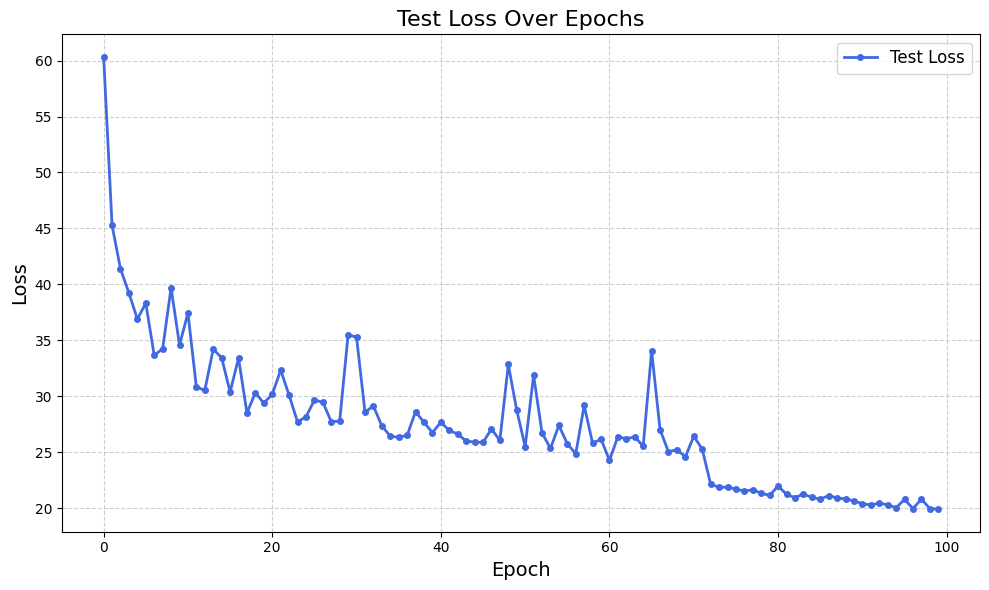

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(test_losses, label='Test Loss', color='royalblue', linewidth=2, marker='o', markersize=4)

plt.title("Test Loss Over Epochs", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("../results/training/Model_A_test_loss.png", dpi=300)
plt.show()